#Dependecies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/SFT_alpaca/

/content/drive/MyDrive/SFT_alpaca


In [3]:
%ls

alpaca_data.json  finetuned_models/     requirements.txt
datasets/         llama-2_alpaca.ipynb  wandb/


In [4]:
!pip install -qqqU -r requirements.txt
!pip install -qqqU datasets trl

In [5]:
import torch, datasets, accelerate, transformers, evaluate, gc
import bitsandbytes as bnb

from transformers import (AutoTokenizer,
                          AutoModelForCausalLM,
                          GenerationConfig,
                          Trainer,
                          TrainingArguments,
                          DataCollatorForLanguageModeling,
                          BitsAndBytesConfig)

from peft import (LoraConfig,
                  get_peft_model,
                  prepare_model_for_kbit_training)

from trl import (SFTTrainer,
                 DataCollatorForCompletionOnlyLM)

from google.colab import runtime


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('http'), PosixPath('8013')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --

In [6]:
# !python -c "import torch; assert torch.cuda.get_device_capability()[0] >= 8, 'Hardware not supported for Flash Attention'"
# !pip install -qqqU ninja packaging
# !MAX_JOBS=4 pip install flash-attn -qqqU --no-build-isolation

# use_flash_attention = False

# if torch.cuda.get_device_capability()[0] >= 8:
#     from utils.llama_patch import replace_attn_with_flash_attn
#     print("Using flash attention")
#     replace_attn_with_flash_attn()
#     use_flash_attention = True

In [7]:
from pprint import pprint

def pp(x):
  pprint(x, compact = True, width = 150)

def cleanup(x):
    if x == 'memory':
        gc.collect()
        torch.cuda.empty_cache()
    elif x == 'runtime':
        runtime.unassign()

In [8]:
from huggingface_hub import login
login()

In [9]:
import wandb
wandb.login()

wandb: Currently logged in as: baur (ft-llmmm). Use `wandb login --relogin` to force relogin


True

#Dataset

In [8]:
from datasets import load_dataset
alpaca = load_dataset('json', data_files='alpaca_data.json')
alpaca

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['output', 'input', 'instruction'],
        num_rows: 52002
    })
})

#Tokenizer, formatting, collator

In [10]:
model_id = 'meta-llama/Llama-2-13b-hf'

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

In [11]:
# set up the collator

def format_one_example(example):
    return f" ### instruction:{example['instruction']}\n ### input: {example['input']}\n ### output: {example['output']}"

# def formatting_prompts_func(examples):
#     output_texts = []
#     for i in range(len(examples['instruction'])):
#         text = format_one_example(examples[i])
#         output_texts.append(text)
#     return output_texts

def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['instruction'])):
        text = f" ### instruction: {example['instruction'][i]}\n ### input: {example['input'][i]}\n ### output: {example['output'][i]}"

        output_texts.append(text)
    return output_texts

response_template = "### output:"
collator = DataCollatorForCompletionOnlyLM(response_template=response_template, tokenizer=tokenizer)

In [13]:
def add_formatted_text(x):
    x['text'] = format_one_example(x)
    return x

In [14]:
alpaca_formatted = alpaca.map(add_formatted_text)

Map:   0%|          | 0/50936 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [15]:
print(alpaca_formatted['train']['text'][4])

 ### instruction:Create an example of a compound sentence from two simple sentences.
 ### input: 
 ### output: He went to work, and he had lunch with his friends.


In [16]:
alpaca_tokenized = alpaca_formatted.map(lambda x: tokenizer(x['text'],
                                                            return_length = True),
                                        batched = True,
                                        #remove_columns = ['instruction','input', 'output']
                                        )


Map:   0%|          | 0/50936 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [17]:
alpaca_filtered = alpaca_tokenized.filter(lambda x : x['length']<512)

Filter:   0%|          | 0/50936 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [39]:
max(alpaca_filtered['train']['length'])

511

In [18]:
alpaca_filtered = alpaca_filtered.map(lambda x : x, batched = True, remove_columns = ['text', 'input_ids', 'attention_mask', 'length'])

Map:   0%|          | 0/50936 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [19]:
alpaca_split = alpaca_filtered['train'].train_test_split(test_size = 1000)

In [20]:
alpaca_split

DatasetDict({
    train: Dataset({
        features: ['output', 'input', 'instruction'],
        num_rows: 49936
    })
    test: Dataset({
        features: ['output', 'input', 'instruction'],
        num_rows: 1000
    })
})

In [23]:
alpaca_split.save_to_disk('datasets/alpaca_512')

Saving the dataset (0/1 shards):   0%|          | 0/49936 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [12]:
from datasets import load_from_disk
alpaca = load_from_disk('datasets/alpaca_512')
alpaca

DatasetDict({
    train: Dataset({
        features: ['output', 'input', 'instruction'],
        num_rows: 49936
    })
    test: Dataset({
        features: ['output', 'input', 'instruction'],
        num_rows: 1000
    })
})

##Word length statistics

In [ ]:
def add_num_words(example):
    example['num_words'] = len(format_one_example(example).split())
    return example

In [ ]:
data = alpaca.map(add_num_words)
data

Map:   0%|          | 0/50002 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'num_words'],
        num_rows: 50002
    })
    val: Dataset({
        features: ['input', 'output', 'instruction', 'num_words'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input', 'output', 'instruction', 'num_words'],
        num_rows: 1000
    })
})

In [ ]:
data_sorted = data.sort('num_words')

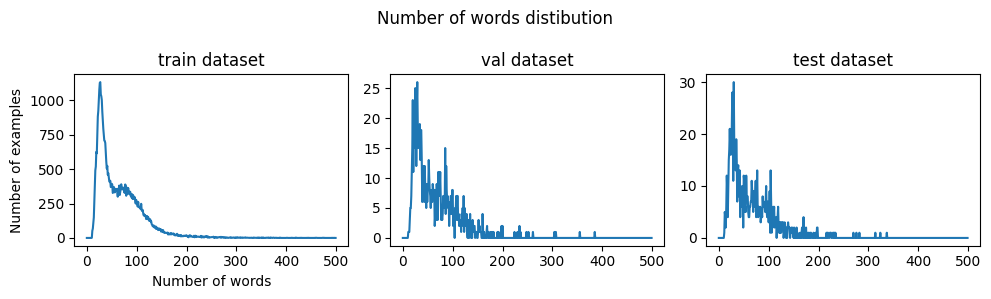

In [ ]:
import numpy as np
len_stat = np.zeros((3,500))
split_names = {'train' : 0, 'val' : 1 , 'test' : 2}

for k, v in split_names.items():
    lengths = np.array(data_sorted[k]['num_words'])
    len_stat[v] = np.array([lengths[lengths ==n].shape[0] for n in range(500)] )

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(10, 3))
fig.suptitle('Number of words distibution')

for k, v  in split_names.items():

  axs[v].plot(len_stat[v, :])
  axs[v].set_title(k + ' dataset')
  if v ==0:
    axs[v].set_xlabel('Number of words')
    axs[v].set_ylabel('Number of examples')

plt.tight_layout()

#Model setup

In [13]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [14]:
def find_all_linear_names(model):
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, bnb.nn.Linear4bit):
            names = name.split(".")
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if "lm_head" in lora_module_names:
        lora_module_names.remove("lm_head")
    return list(lora_module_names)

In [15]:
def prepare_quant_model(model_id = model_id):

    nf4_config = BitsAndBytesConfig(load_in_4bit=True,
                                    bnb_4bit_quant_type="nf4",
                                    bnb_4bit_use_double_quant=True,
                                    bnb_4bit_compute_dtype=torch.bfloat16
                                    )

    model = AutoModelForCausalLM.from_pretrained(model_id,
                                                quantization_config=nf4_config,
                                                use_cache=False,
                                                device_map='auto',
                                                torch_dtype = torch.bfloat16
                                                )


    # if use_flash_attention:
    #     from utils.llama_patch import forward
    #     assert model.model.layers[0].self_attn.forward.__doc__ == forward.__doc__, "Model is not using flash attention"


    model.gradient_checkpointing_enable()
    model = prepare_model_for_kbit_training(model)

    # if use_flash_attention:
    #     from utils.llama_patch import upcast_layer_for_flash_attention
    #     model = upcast_layer_for_flash_attention(model, torch.bfloat16)

    return model

def get_lora_model(model, lora_rank = 32):

    config = LoraConfig(r=lora_rank,
                        lora_alpha=16,
                        target_modules=find_all_linear_names(model),
                        lora_dropout=0.,
                        bias="none",
                        task_type="CAUSAL_LM")

    model = get_peft_model(model, config)

    return model

#Training

In [16]:
%env WANDB_PROJECT=sft_llama_alpaca_bm
WANDB_LOG_MODEL="checkpoint"

env: WANDB_PROJECT=sft_llama_alpaca_bm


In [ ]:
# run = wandb.init(project = 'sft_llama_alpaca_bm',
#                  entity='ft-llmmm')

In [17]:
def training_args_config(lora_rank = 16,
                         num_epochs = 1,
                         lr = 1e-3,
                         weight_decay = 0.,
                         batch_size = 8,
                         gradient_accumulation_steps = 4,
                         group_by_length = True,
                         eval_steps = 500,
                         logging_steps = 500,
                         save_steps = 500,
                         find_batch_size = True,
                         lr_schedule = 'linear',
                         warmup_ratio = 0.03,
                         output_dir = 'finetuned_models/llama',
                         run_name = None
                         ):

    params = {

    #-----training----------------
    'num_train_epochs' : num_epochs,
    'learning_rate' : lr,
    'weight_decay' : weight_decay,
    'dataloader_num_workers' : 4,
    'per_device_train_batch_size' : batch_size,
    'per_device_eval_batch_size' : batch_size,
    'group_by_length' : group_by_length,
    'auto_find_batch_size' : find_batch_size,
    'lr_scheduler_type' : lr_schedule,
    'warmup_ratio' : warmup_ratio,

    #-----efficient training-----
    'gradient_accumulation_steps' : gradient_accumulation_steps,
    'gradient_checkpointing' : True,
    'optim' : 'paged_adamw_8bit',
    'bf16' : True,

    #-----logging----------------
    'report_to' : 'wandb',
    'output_dir' : output_dir,

    'evaluation_strategy' : "steps",
    #'eval_steps' : eval_steps,

    'logging_strategy' : 'steps',
    'logging_steps' : logging_steps,

    'save_strategy' : "steps",
    'save_steps' : save_steps,

    'save_total_limit' : 2,
    'load_best_model_at_end' : True,
    'metric_for_best_model' : "eval_loss",
    'greater_is_better' : False,

    'run_name' : f'lr{lr:.0e}_bs{batch_size}' + ('_' + run_name if run_name is not None else ''),
    }

    params['output_dir'] = params['output_dir'] + '/' + params['run_name']

    return params

In [18]:
r = 16

model= prepare_quant_model(model_id = model_id)
model = get_lora_model(model, lora_rank = r)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [19]:
tot_steps = alpaca['train'].num_rows / (32*4)
tot_steps/10

39.0125

In [20]:
hyperparams = training_args_config( lora_rank = r,
                                    num_epochs = 3,
                                    lr = 5e-5,
                                    weight_decay = 0,
                                    batch_size = 32,
                                    gradient_accumulation_steps = 4,
                                    group_by_length = True,
                                    eval_steps = 39,
                                    logging_steps = 39,
                                    save_steps = 39,
                                    find_batch_size = True,
                                    lr_schedule = 'constant',
                                    warmup_ratio = 0.03,
                                    output_dir = 'finetuned_models/llama13B',
                                    run_name = None
                                    )
pp(hyperparams)

trainer = SFTTrainer(   model,
                        args = TrainingArguments(**hyperparams),
                        max_seq_length=512,
                        train_dataset=alpaca['train'],
                        eval_dataset=alpaca['test'],
                        formatting_func=formatting_prompts_func,
                        #dataset_text_field = 'text',
                        data_collator=collator,
)

{'auto_find_batch_size': True,
 'bf16': True,
 'dataloader_num_workers': 4,
 'evaluation_strategy': 'steps',
 'gradient_accumulation_steps': 4,
 'gradient_checkpointing': True,
 'greater_is_better': False,
 'group_by_length': True,
 'learning_rate': 5e-05,
 'load_best_model_at_end': True,
 'logging_steps': 39,
 'logging_strategy': 'steps',
 'lr_scheduler_type': 'constant',
 'metric_for_best_model': 'eval_loss',
 'num_train_epochs': 3,
 'optim': 'paged_adamw_8bit',
 'output_dir': 'finetuned_models/llama13B/lr5e-05_bs32',
 'per_device_eval_batch_size': 32,
 'per_device_train_batch_size': 32,
 'report_to': 'wandb',
 'run_name': 'lr5e-05_bs32',
 'save_steps': 39,
 'save_strategy': 'steps',
 'save_total_limit': 2,
 'warmup_ratio': 0.03,
 'weight_decay': 0}


Using pad_token, but it is not set yet.


In [21]:
print_trainable_parameters(model)

trainable params: 62586880 || all params: 6734566400 || trainable%: 0.9293379303528732


In [ ]:
trainer.evaluate()

In [ ]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
39,1.047200,1.101726
78,1.019200,1.074891
117,0.967900,1.098477
156,0.936100,1.167456
195,0.973800,1.124168
234,1.043100,1.080904
273,0.974800,1.077281
312,0.943900,1.108242
351,0.931900,1.116877
390,0.975200,1.109294


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using t

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-3435b262f1ae>", line 1, in <cell line: 1>
    trainer.train()
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1539, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/accelerate/utils/memory.py", line 136, in decorator
    return function(batch_size, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1901, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_eval)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2237, in _maybe_log_save_evaluate
    self._save_checkpoint(model, trial, metrics=metrics)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", lin

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
    self.ctx_run(self.run)
  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
    sel

In [ ]:
wandb.finish();

In [35]:
cleanup('memory')

In [ ]:
cleanup('runtime')

# Inference

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from datasets import load_from_disk
data = load_from_disk('artifacts/wiki+eli5<400')
wiki = data.filter(lambda example : example['source'] == 'simple_wiki')
eli5 = data.filter(lambda example : example['source'] == 'ELI5')

In [ ]:
base_models = ['meta-llama/Llama-2-7b-hf',
               'meta-llama/Llama-2-13b-hf']

lora_layers_trained = ['finetuned_models/llama/wiki, lr = 1e-5, wd = 0.1/checkpoint-576',
                       'finetuned_models/llama13B/r16_lr1e-05_wd0.1_bs16_wiki/checkpoint-936']

idx = 1

tokenizer = AutoTokenizer.from_pretrained(base_models[idx])
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_4bit = AutoModelForCausalLM.from_pretrained(base_models[idx], quantization_config=bnb_config)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
from peft import PeftModel

model_trained = PeftModel.from_pretrained(model = model_4bit,
                    model_id = lora_layers_trained[idx],
                    torch_dtype = torch.bfloat16,
                    is_trainable = False)

#model = model_trained.merge_and_unload()

In [ ]:
def generate_examples(model, data):

    model.config.pad_token_id = model.config.eos_token_id

    generation_config = GenerationConfig(   num_beams = 4,
                                            #max_length = 100,
                                            max_new_tokens = 100,
                                            do_sample = True,
                                            temperature = 1.,
                                            top_k = 50,
                                            top_p = 0.8,
                                            repetition_penalty = 1.0,
                                            #pad_token_id = model.config.eos_token_id
                                        )




    prompts = [ f'### Human: {q}\n ### Assistant:' for q in data['question'] ]
    input = tokenizer(prompts, return_tensors = 'pt', padding = True).to(device)


    output_ids = model.generate(input_ids = input['input_ids'],
                                attention_mask = input['attention_mask'],
                                generation_config = generation_config,
                                pad_token_id = model.config.eos_token_id,
                                )

    predictions =  [tokenizer.decode(ids, skip_special_tokens = True) for ids in output_ids]

    return predictions

In [ ]:
len(wiki['test'])

1000

In [ ]:
import random
random.seed(123321)

idx = [random.randint(0,len(wiki['test'])) for i in range(10)]

In [ ]:
idx

[141, 178, 704, 255, 885, 863, 382, 270, 904, 32]

In [ ]:
batch = wiki['test'][idx]

references = batch['QA']
predictions = generate_examples(model_4bit, batch)
predictions_trained = generate_examples(model_trained, batch)

In [ ]:
for ref, pred, pred_trained in zip(references, predictions, predictions_trained):
    print(f'Reference: {ref}')
    print(50*'-')
    print(f'Prediction: {pred}')
    print(50*'-')
    print(f'SFT: {pred_trained}')
    print(150*'=')


## Rouge

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
!pip install evaluate rouge_score -qqqU
import evaluate
rouge = evaluate.load("rouge")

In [ ]:
result = rouge.compute(predictions=["The quick black tiger jumps over the lazy cat"],
                       references=["The quick brown fox walks over the lazy dog"])
print(result)

{'rouge1': 0.5555555555555556, 'rouge2': 0.375, 'rougeL': 0.5555555555555556, 'rougeLsum': 0.5555555555555556}


In [ ]:
references = []
predictions = []
predictions_trained = []

In [ ]:
for i in tqdm(range(50)):
    batch = wiki['test'][i*10 : (i+1)*10]

    references += batch['QA']
    predictions += generate_examples(model_4bit, batch)
    predictions_trained += generate_examples(model_trained, batch)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
len(predictions)

500

In [ ]:
scores_base = rouge.compute(predictions=predictions,
                            references=references)

scores_trained = rouge.compute(predictions=predictions_trained,
                               references=references)

print(f'Base model rouge scores:    {scores_base}')
print(f'Trained model rouge scores: {scores_trained}')


Base model rouge scores:    {'rouge1': 0.5073341657308709, 'rouge2': 0.31618795492913715, 'rougeL': 0.4154074302351301, 'rougeLsum': 0.42934900439508294}
Trained model rouge scores: {'rouge1': 0.5095403616375263, 'rouge2': 0.3174833679008695, 'rougeL': 0.4177316099029409, 'rougeLsum': 0.43152785924481174}


For Llama 7B there is essentially no improvement in rouge score.

Base Llama-2-7B: {'rouge1': 0.468, 'rouge2': 0.279, 'rougeL': 0.386, 'rougeLsum': 0.399}

SFT on wiki: {'rouge1': 0.470, 'rouge2': 0.279, 'rougeL': 0.385, 'rougeLsum': 0.398}

For Llama 13B there is also no improvement in rouge score.

Base Llama-2-7B: {'rouge1': 0.507, 'rouge2': 0.316, 'rougeL': 0.415, 'rougeLsum': 0.429}

SFT on wiki: {'rouge1': 0.509, 'rouge2': 0.317, 'rougeL': 0.418, 'rougeLsum': 0.431}

In [ ]:
del model_4bit
del model_trained

In [ ]:
cleanup('memory')